<a href="https://colab.research.google.com/github/saspav/Deep-Learning-2022/blob/main/19_1_%5Bhw%5Dautoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
%matplotlib inline

# from scipy.misc import imread, imresize
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_valid = train_test_split(data, train_size = 0.8)

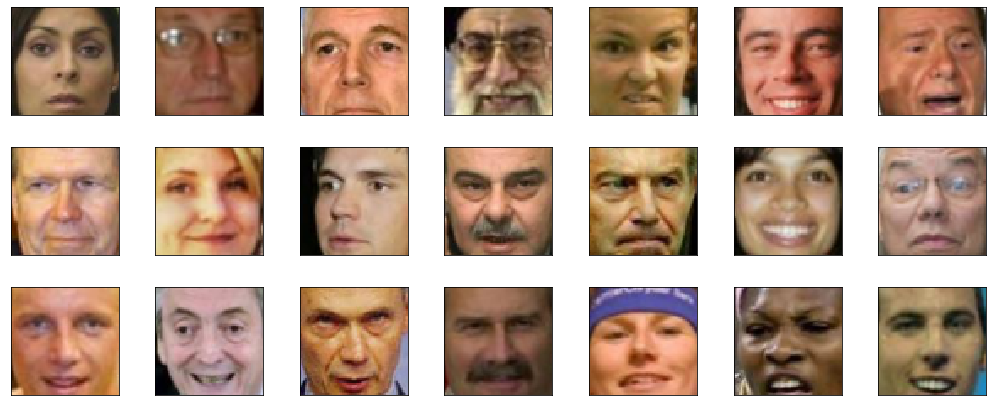

In [5]:
def show_images(images, h, w, n_row=3, n_col=7, channels=3):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.9, hspace=.3)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if channels == 3:
            if images[i].shape[2] is 3:
                plt.imshow(images[i], cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            else:
                plt.imshow(np.rollaxis(images[i], 0, 3), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        elif channels == 1:
            plt.imshow(images[i].reshape((h, w)), cmap='gray') 
        else:
            print('Проблема с каналами')
        plt.xticks(())
        plt.yticks(())
        

image_h, image_w = data.shape[1:3]
show_images(data_train[:21], image_h, image_w, 3, 7)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [6]:
dim_code = 128 # размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [7]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 64->32

            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 32 -> 16

            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 -> 8

            nn.Flatten(),
            nn.Linear(8 * 8 * 64, dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 8 * 8 * 64),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 64, stride = (2,2), kernel_size = 3, padding = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, stride = (2,2), kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, stride = (2,2), kernel_size = 3, padding = 2, output_padding = 1),
            nn.Sigmoid()
        )      
      
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [8]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, use CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.


In [9]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(DEVICE)

optimizer = torch.optim.AdamW(autoencoder.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [10]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x.to(DEVICE)

        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        pred_x, _ = model(train_x)
        
        # calculate loss
        loss = loss_fn(pred_x, train_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
    return train_ep_loss


def valid_epoch(model, valid_loader, loss_fn):
    model.eval()
    valid_ep_loss = 0.
    counter = 0.
    for valid_x in valid_loader:
        # get the output from the model
        valid_x = valid_x.to(DEVICE)
        pred_x, _ = model(valid_x)

        # calculate loss
        loss = loss_fn(pred_x, valid_x)
        valid_ep_loss += loss.item() 
        
        counter += 1

    valid_ep_loss /= counter
    return valid_ep_loss


def train(model, train_loader, valid_loader, loss_fn, optimizer, epochs, scheduler=None):
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(epochs)):

        train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Epoch: {}/{}...".format(epoch+1, epochs), 
              "Loss: {:.6f}...".format(train_loss), 
              "Valid Loss: {:.6f}".format(valid_loss))
    return train_losses, valid_losses

In [11]:
train_loader = torch.utils.data.DataLoader(torch.Tensor(data_train.swapaxes(1,3).swapaxes(2,3)), batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.Tensor(data_valid.swapaxes(1,3).swapaxes(2,3)), batch_size=64, shuffle=False)

ae_train_losses, ae_valid_losses = train(autoencoder, train_loader, valid_loader, criterion, optimizer, 40, scheduler)

  2%|▎         | 1/40 [00:13<08:36, 13.23s/it]

Epoch: 1/40... Loss: 0.018099... Valid Loss: 0.009417


  5%|▌         | 2/40 [00:18<05:31,  8.71s/it]

Epoch: 2/40... Loss: 0.007296... Valid Loss: 0.006486


  8%|▊         | 3/40 [00:24<04:29,  7.29s/it]

Epoch: 3/40... Loss: 0.005184... Valid Loss: 0.005049


 10%|█         | 4/40 [00:29<03:58,  6.63s/it]

Epoch: 4/40... Loss: 0.004327... Valid Loss: 0.004429


 12%|█▎        | 5/40 [00:35<03:39,  6.28s/it]

Epoch: 5/40... Loss: 0.003919... Valid Loss: 0.004033


 15%|█▌        | 6/40 [00:41<03:33,  6.28s/it]

Epoch: 6/40... Loss: 0.003540... Valid Loss: 0.003536


 18%|█▊        | 7/40 [00:47<03:20,  6.06s/it]

Epoch: 7/40... Loss: 0.003402... Valid Loss: 0.003355


 20%|██        | 8/40 [00:53<03:09,  5.91s/it]

Epoch: 8/40... Loss: 0.003183... Valid Loss: 0.003081


 22%|██▎       | 9/40 [00:58<02:59,  5.80s/it]

Epoch: 9/40... Loss: 0.003119... Valid Loss: 0.003462


 25%|██▌       | 10/40 [01:04<02:51,  5.72s/it]

Epoch: 10/40... Loss: 0.002950... Valid Loss: 0.002975


 28%|██▊       | 11/40 [01:09<02:44,  5.66s/it]

Epoch: 11/40... Loss: 0.002668... Valid Loss: 0.002613


 30%|███       | 12/40 [01:15<02:37,  5.62s/it]

Epoch: 12/40... Loss: 0.002656... Valid Loss: 0.002550


 32%|███▎      | 13/40 [01:20<02:30,  5.59s/it]

Epoch: 13/40... Loss: 0.002588... Valid Loss: 0.002538


 35%|███▌      | 14/40 [01:26<02:24,  5.57s/it]

Epoch: 14/40... Loss: 0.002526... Valid Loss: 0.002537


 38%|███▊      | 15/40 [01:31<02:19,  5.56s/it]

Epoch: 15/40... Loss: 0.002500... Valid Loss: 0.002470


 40%|████      | 16/40 [01:37<02:13,  5.55s/it]

Epoch: 16/40... Loss: 0.002468... Valid Loss: 0.002479


 42%|████▎     | 17/40 [01:42<02:07,  5.56s/it]

Epoch: 17/40... Loss: 0.002432... Valid Loss: 0.002411


 45%|████▌     | 18/40 [01:48<02:02,  5.56s/it]

Epoch: 18/40... Loss: 0.002395... Valid Loss: 0.002405


 48%|████▊     | 19/40 [01:54<01:56,  5.56s/it]

Epoch: 19/40... Loss: 0.002402... Valid Loss: 0.002505


 50%|█████     | 20/40 [01:59<01:51,  5.56s/it]

Epoch: 20/40... Loss: 0.002385... Valid Loss: 0.002553


 52%|█████▎    | 21/40 [02:05<01:45,  5.56s/it]

Epoch: 21/40... Loss: 0.002316... Valid Loss: 0.002325


 55%|█████▌    | 22/40 [02:10<01:40,  5.57s/it]

Epoch: 22/40... Loss: 0.002307... Valid Loss: 0.002325


 57%|█████▊    | 23/40 [02:16<01:34,  5.56s/it]

Epoch: 23/40... Loss: 0.002293... Valid Loss: 0.002299


 60%|██████    | 24/40 [02:21<01:28,  5.56s/it]

Epoch: 24/40... Loss: 0.002324... Valid Loss: 0.002311


 62%|██████▎   | 25/40 [02:27<01:23,  5.56s/it]

Epoch: 25/40... Loss: 0.002290... Valid Loss: 0.002319


 65%|██████▌   | 26/40 [02:33<01:17,  5.56s/it]

Epoch: 26/40... Loss: 0.002289... Valid Loss: 0.002294


 68%|██████▊   | 27/40 [02:38<01:12,  5.56s/it]

Epoch: 27/40... Loss: 0.002281... Valid Loss: 0.002278


 70%|███████   | 28/40 [02:44<01:06,  5.56s/it]

Epoch: 28/40... Loss: 0.002263... Valid Loss: 0.002282


 72%|███████▎  | 29/40 [02:49<01:01,  5.56s/it]

Epoch: 29/40... Loss: 0.002283... Valid Loss: 0.002284


 75%|███████▌  | 30/40 [02:55<00:55,  5.56s/it]

Epoch: 30/40... Loss: 0.002266... Valid Loss: 0.002265


 78%|███████▊  | 31/40 [03:00<00:50,  5.60s/it]

Epoch: 31/40... Loss: 0.002276... Valid Loss: 0.002255


 80%|████████  | 32/40 [03:06<00:44,  5.62s/it]

Epoch: 32/40... Loss: 0.002257... Valid Loss: 0.002260


 82%|████████▎ | 33/40 [03:12<00:39,  5.60s/it]

Epoch: 33/40... Loss: 0.002250... Valid Loss: 0.002256


 85%|████████▌ | 34/40 [03:17<00:33,  5.59s/it]

Epoch: 34/40... Loss: 0.002264... Valid Loss: 0.002256


 88%|████████▊ | 35/40 [03:23<00:27,  5.59s/it]

Epoch: 35/40... Loss: 0.002239... Valid Loss: 0.002249


 90%|█████████ | 36/40 [03:28<00:22,  5.58s/it]

Epoch: 36/40... Loss: 0.002255... Valid Loss: 0.002248


 92%|█████████▎| 37/40 [03:34<00:16,  5.58s/it]

Epoch: 37/40... Loss: 0.002274... Valid Loss: 0.002251


 95%|█████████▌| 38/40 [03:40<00:11,  5.57s/it]

Epoch: 38/40... Loss: 0.002239... Valid Loss: 0.002262


 98%|█████████▊| 39/40 [03:45<00:05,  5.57s/it]

Epoch: 39/40... Loss: 0.002247... Valid Loss: 0.002249


100%|██████████| 40/40 [03:51<00:00,  5.78s/it]

Epoch: 40/40... Loss: 0.002249... Valid Loss: 0.002247


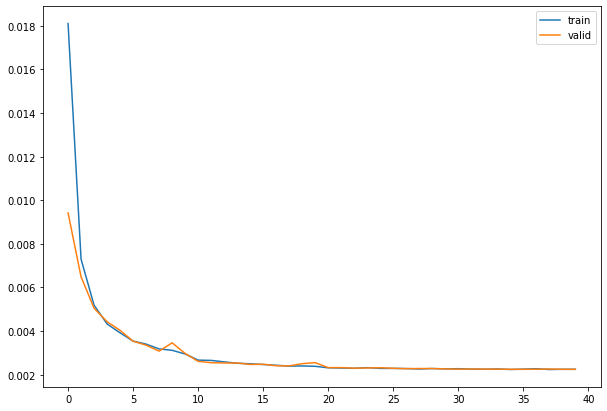

In [12]:
fig = plt.figure(figsize=(10, 7))
plt.plot(ae_train_losses, label='train')
plt.plot(ae_valid_losses, label='valid')
plt.legend(loc="upper right")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [13]:
def plot_pair(img1, img2, idx=0):
    img1 = img1[idx].cpu().detach().numpy()
    img2 = img2[idx].cpu().detach().numpy()
   
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5))
    axes[0].imshow(np.rollaxis(img1, 0, 3))
    axes[1].imshow(np.rollaxis(img2, 0, 3))
    axes[0].axis('off')
    axes[1].axis('off')
    fig.tight_layout()

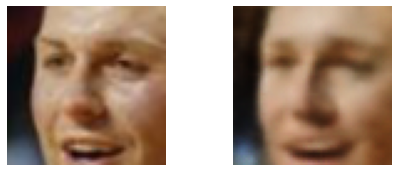

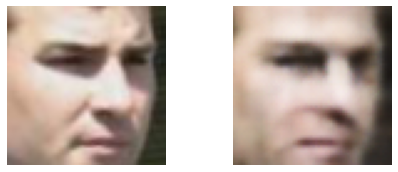

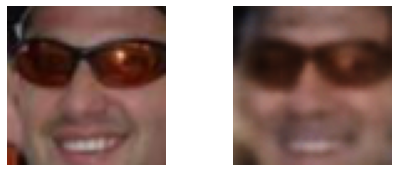

In [14]:
some_samples = next(iter(valid_loader))

autoencoder.eval()
with torch.no_grad():
    prediction, _ = autoencoder(some_samples.cuda())
    for idx in range(3):
        plot_pair(some_samples, prediction, idx)
        # слева оригинал, справа - восстановленное изображение

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

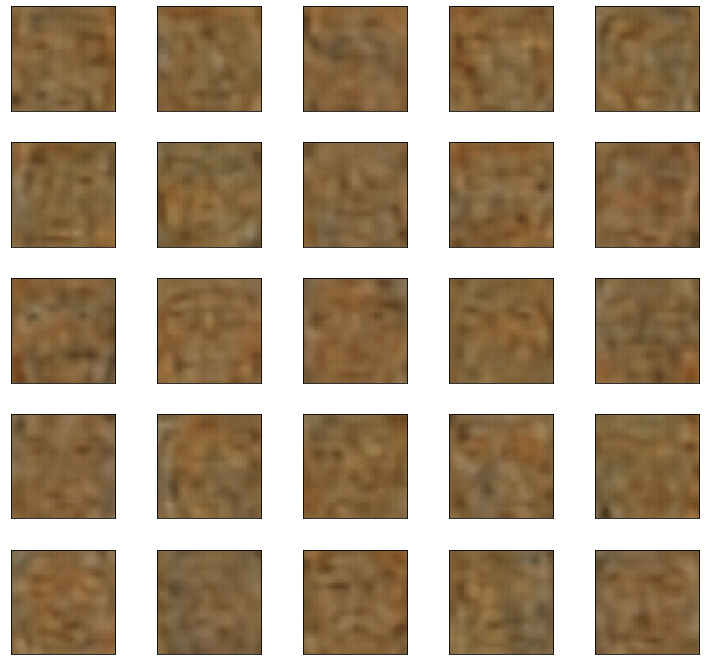

In [15]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
z = torch.FloatTensor(z).to(DEVICE)
output = autoencoder.decoder(z)
output = output.data.cpu().numpy()
show_images(output, image_h, image_w, n_row=5, n_col=5, channels=3)

На картинках слегка угадываются границы лиц

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [16]:
smiling_images = [n for n, x in attrs.iterrows() if x['Smiling'] > 1][:21] 
no_smiling_images = [n for n, x in attrs.iterrows() if x['Smiling'] < -1][:21] 

# достаем необходимые образцы данных из data
smiling_data = data[smiling_images]
no_smiling_data = data[no_smiling_images]

# приводим к тензорам и меняем порядок осей
smiling_data = torch.Tensor(smiling_data.swapaxes(1,3).swapaxes(2,3))
no_smiling_data = torch.Tensor(no_smiling_data.swapaxes(1,3).swapaxes(2,3))

# получаем латентные представления улыбающихся и неулыбающихся людей
autoencoder.eval()

with torch.no_grad():
  _, latent_smiling = autoencoder(smiling_data.cuda())
  _, latent_no_smiling = autoencoder(no_smiling_data.cuda())

# вектор улыбки
smile_vector = latent_smiling.mean(dim = 0) - latent_no_smiling.mean(dim=0)


def make_smile(autoencoder, data, smile_vector=smile_vector):
  autoencoder.eval()
  with torch.no_grad():
    latent_space = autoencoder.encoder(data.cuda())
    latent_space += smile_vector
    reconstructed = autoencoder.decoder(latent_space).view(-1, 3, 64, 64)
    return reconstructed

In [17]:
new_data = make_smile(autoencoder, no_smiling_data.cuda(), smile_vector.cuda())

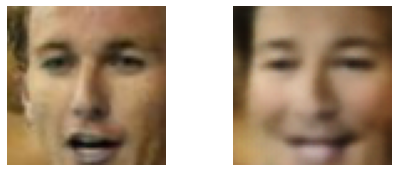

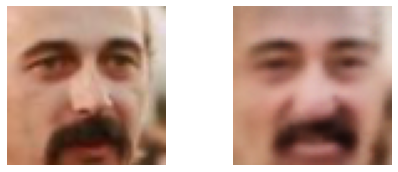

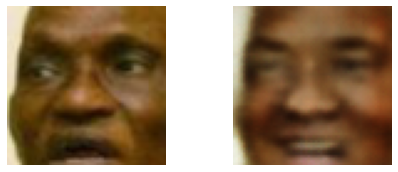

In [18]:
for idx in range(3):
  plot_pair(no_smiling_data, new_data, idx) 

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [19]:
from torchvision import datasets

batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [20]:
features = 10

class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(),

            nn.Conv2d(10, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # batch_size x 20 x 14 x 14

            nn.Conv2d(20, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # batch_size x 40 x 7 x 7 

            nn.Flatten(),

            nn.Linear(40 * 7 * 7, features * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(features, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)),  # 7
            nn.Upsample(scale_factor=2),  # 7 -> 14
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size=3, stride=1, padding=1),  # 14 -> 14
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logvar>
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]
        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)

        # decoding
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [21]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #<напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma)) 
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    #<соедините тут две компоненты лосса. Mind the sign!>
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)  



def vae_train(model, train_loader, loss_fn, optimizer, epochs, scheduler=None):
    train_losses = []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_ep_loss = 0.

        for X_batch, _ in train_loader:
            optimizer.zero_grad()

            X_batch = X_batch.to(DEVICE)
            mu_train, logvar_train, reconstruction = model(X_batch)
            loss = loss_fn(X_batch, mu_train, logvar_train, reconstruction)
            loss.backward()

            optimizer.step()
            train_ep_loss += loss.cpu().item()

        avg_loss = train_ep_loss/len(train_loader)
        train_losses.append(avg_loss)

        if scheduler:
            scheduler.step()

        print(f'Epoch: {epoch+1}. Loss: {avg_loss}')

    return train_losses

И обучим модель:

In [22]:
vae = VAE().to(DEVICE)

optimizer = optim.Adam(vae.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 5)

vae_train_losses = vae_train(vae, train_loader, loss_vae, optimizer, 30, scheduler)

  3%|▎         | 1/30 [00:17<08:21, 17.30s/it]

Epoch: 1. Loss: 4369.4690125


  7%|▋         | 2/30 [00:34<08:01, 17.18s/it]

Epoch: 2. Loss: 3636.579476171875


 10%|█         | 3/30 [00:51<07:42, 17.14s/it]

Epoch: 3. Loss: 3541.2816520833335


 13%|█▎        | 4/30 [01:08<07:26, 17.16s/it]

Epoch: 4. Loss: 3487.4649717447915


 17%|█▋        | 5/30 [01:25<07:09, 17.19s/it]

Epoch: 5. Loss: 3453.9096688802083


 20%|██        | 6/30 [01:43<06:52, 17.17s/it]

Epoch: 6. Loss: 3389.146376041667


 23%|██▎       | 7/30 [02:00<06:35, 17.21s/it]

Epoch: 7. Loss: 3379.853947265625


 27%|██▋       | 8/30 [02:17<06:18, 17.20s/it]

Epoch: 8. Loss: 3373.969314453125


 30%|███       | 9/30 [02:34<06:01, 17.19s/it]

Epoch: 9. Loss: 3370.63983046875


 33%|███▎      | 10/30 [02:51<05:44, 17.22s/it]

Epoch: 10. Loss: 3367.28031015625


 37%|███▋      | 11/30 [03:09<05:26, 17.21s/it]

Epoch: 11. Loss: 3359.7316384114583


 40%|████      | 12/30 [03:26<05:08, 17.15s/it]

Epoch: 12. Loss: 3358.6308458333333


 43%|████▎     | 13/30 [03:43<04:50, 17.10s/it]

Epoch: 13. Loss: 3357.134669140625


 47%|████▋     | 14/30 [04:00<04:33, 17.10s/it]

Epoch: 14. Loss: 3356.9190795572918


 50%|█████     | 15/30 [04:19<04:23, 17.60s/it]

Epoch: 15. Loss: 3356.9775483072917


 53%|█████▎    | 16/30 [04:36<04:03, 17.42s/it]

Epoch: 16. Loss: 3355.2368247395834


 57%|█████▋    | 17/30 [04:53<03:45, 17.31s/it]

Epoch: 17. Loss: 3355.0656221354166


 60%|██████    | 18/30 [05:10<03:26, 17.22s/it]

Epoch: 18. Loss: 3356.4316321614583


 63%|██████▎   | 19/30 [05:27<03:11, 17.40s/it]

Epoch: 19. Loss: 3356.2046776041666


 67%|██████▋   | 20/30 [05:45<02:53, 17.32s/it]

Epoch: 20. Loss: 3356.544683463542


 70%|███████   | 21/30 [06:02<02:35, 17.23s/it]

Epoch: 21. Loss: 3355.5205080729165


 73%|███████▎  | 22/30 [06:19<02:17, 17.15s/it]

Epoch: 22. Loss: 3355.942105078125


 77%|███████▋  | 23/30 [06:36<01:59, 17.12s/it]

Epoch: 23. Loss: 3356.5022638020832


 80%|████████  | 24/30 [06:53<01:42, 17.09s/it]

Epoch: 24. Loss: 3355.0512162760415


 83%|████████▎ | 25/30 [07:10<01:25, 17.07s/it]

Epoch: 25. Loss: 3355.0488740885417


 87%|████████▋ | 26/30 [07:27<01:08, 17.06s/it]

Epoch: 26. Loss: 3355.392439453125


 90%|█████████ | 27/30 [07:44<00:51, 17.06s/it]

Epoch: 27. Loss: 3356.035372916667


 93%|█████████▎| 28/30 [08:01<00:34, 17.09s/it]

Epoch: 28. Loss: 3355.7322115885418


 97%|█████████▋| 29/30 [08:18<00:17, 17.12s/it]

Epoch: 29. Loss: 3356.231720442708


100%|██████████| 30/30 [08:35<00:00, 17.18s/it]

Epoch: 30. Loss: 3355.1877548177085


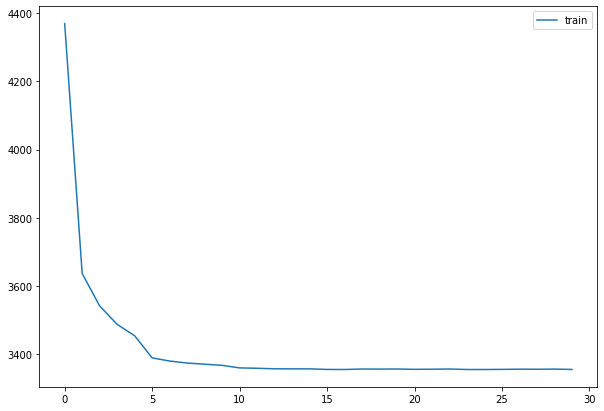

In [23]:
fig = plt.figure(figsize=(10, 7))
plt.plot(vae_train_losses, label='train')
plt.legend(loc="upper right")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

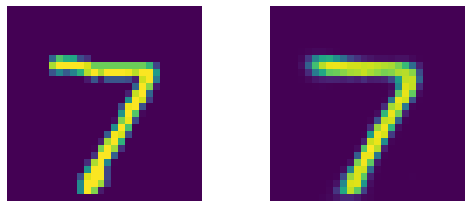

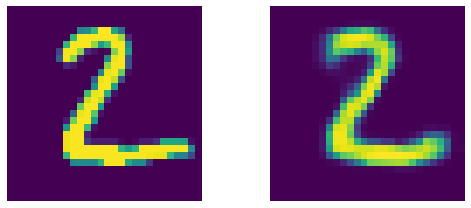

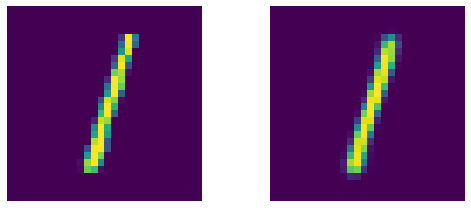

In [24]:
def pair_digit(dim1, dim2, idx=0):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axes[0].imshow(dim1[idx].cpu().detach().squeeze())
    axes[1].imshow(dim2[idx].cpu().detach().squeeze())
    axes[0].axis('off')
    axes[1].axis('off')
    fig.tight_layout()

some_samples, _ = next(iter(test_loader))

vae.eval()

with torch.no_grad():
    _, _, prediction = vae(some_samples.cuda())
    for idx in range(3):
        pair_digit(some_samples, prediction, idx)
        # слева оригинал, справа - восстановленное изображение

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

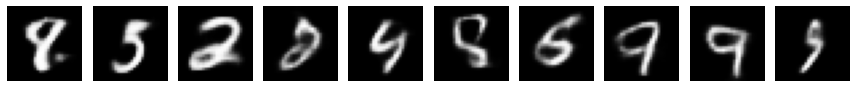

In [25]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(10)])
with torch.no_grad():
    output = vae.decode(torch.Tensor(z).cuda())
    output = output.cpu().detach().squeeze()
    
    fig, axes = plt.subplots(nrows=1, ncols=features, figsize=(12, 4))
    for idx in range(features):
        axes[idx].imshow(output[idx], cmap='gray')
        axes[idx].axis('off')
    fig.tight_layout()   

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

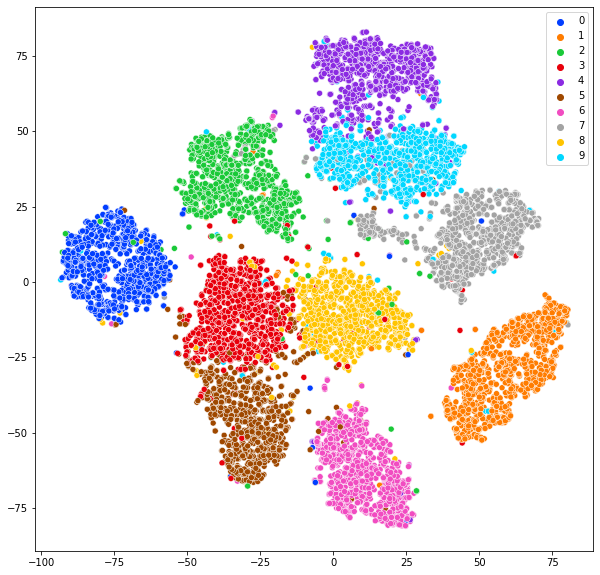

In [26]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE
import seaborn as sns

vae.eval()
latent_representation = []
with torch.no_grad():
    for test_batch, _ in test_loader:
        mu, logvar = vae.encode(test_batch.cuda())
        z = vae.gaussian_sampler(mu, logvar)
        latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

plt.figure(figsize = (10,10))
sns.scatterplot(pred[:, 0], pred[:, 1], hue=test_dataset.targets, palette=sns.color_palette('bright', 10))
plt.show()

Что вы думаете о виде латентного представления?

#### Все цифры сгруппированы по облакам, причем облака с цифрами с похожим начертанием располагаются рядом: 
#### 8-3-5-6, 4-9-7 1

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [27]:
features = 10


class CVAE(nn.Module):
    def __init__(self):
        """
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", т.е. encoder должен
        кодировать картинку в 2 переменные -- mu и logsigma>
        """
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),

            nn.Linear(300, 150),
            nn.BatchNorm1d(150),
            nn.LeakyReLU(),

            nn.Linear(150, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),

            nn.Linear(50, features * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(features + 10, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),

            nn.Linear(50, 150),
            nn.BatchNorm1d(150),
            nn.LeakyReLU(),

            nn.Linear(150, 300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),

            nn.Linear(300, 28 * 28),
            nn.Unflatten(1, (1, 28, 28)),

            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        """ <реализуйте forward проход энкодера
        в качестве возвращаемых переменных mu, logsigma и класс картинки>"""
        a = torch.flatten(x, start_dim=1)
        a = torch.cat([a, class_num], dim=1)
        z = self.encoder(a).view(-1, 2, features)
        mu = z[:, 0, :]
        logsigma = z[:, 1, :]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            z = mu + (std * eps)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        """ <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction> """
        reconstruction = self.decoder(torch.cat([z, class_num], dim=1))
        return reconstruction

    def forward(self, x, class_num):
        """ <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных mu, logsigma и reconstruction> """
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [28]:
def cvae_train(model, train_loader, loss_fn, optimizer, epochs, scheduler=None):
    train_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        train_ep_loss = 0.

        for x_batch, class_num in train_loader:
            optimizer.zero_grad()

            x_batch = x_batch.to(DEVICE)
            class_num = F.one_hot(class_num, 10)
            class_num = class_num.to(DEVICE)

            mu_, logsigma_, reconstruction = model(x_batch, class_num)
            loss = loss_fn(x_batch, mu_, logsigma_, reconstruction)
            loss.backward()
            optimizer.step()
            train_ep_loss += loss.cpu().item()

        avg_loss = train_ep_loss / len(train_loader)
        train_losses.append(avg_loss)

        if scheduler:
            scheduler.step()

        print(f'Epoch: {epoch + 1}. Loss: {avg_loss}')
    return train_losses


cvae = CVAE().to(DEVICE)
optimizer = optim.Adam(cvae.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 5)
cvae_train_losses = cvae_train(cvae, train_loader, loss_vae, optimizer, 30, scheduler)

  3%|▎         | 1/30 [00:20<10:02, 20.76s/it]

Epoch: 1. Loss: 4483.30459765625


  7%|▋         | 2/30 [00:38<08:54, 19.09s/it]

Epoch: 2. Loss: 3891.28700078125


 10%|█         | 3/30 [00:56<08:19, 18.50s/it]

Epoch: 3. Loss: 3769.6044625


 13%|█▎        | 4/30 [01:14<07:53, 18.22s/it]

Epoch: 4. Loss: 3703.7998216145834


 17%|█▋        | 5/30 [01:33<07:42, 18.51s/it]

Epoch: 5. Loss: 3654.381208984375


 20%|██        | 6/30 [01:51<07:19, 18.32s/it]

Epoch: 6. Loss: 3544.44264609375


 23%|██▎       | 7/30 [02:09<06:57, 18.16s/it]

Epoch: 7. Loss: 3526.0938796875


 27%|██▋       | 8/30 [02:26<06:36, 18.03s/it]

Epoch: 8. Loss: 3515.4376555989584


 30%|███       | 9/30 [02:44<06:17, 17.96s/it]

Epoch: 9. Loss: 3507.19918125


 33%|███▎      | 10/30 [03:02<05:59, 17.98s/it]

Epoch: 10. Loss: 3504.6075567708335


 37%|███▋      | 11/30 [03:20<05:40, 17.92s/it]

Epoch: 11. Loss: 3490.9929088541667


 40%|████      | 12/30 [03:38<05:22, 17.92s/it]

Epoch: 12. Loss: 3489.0925186197915


 43%|████▎     | 13/30 [03:57<05:11, 18.30s/it]

Epoch: 13. Loss: 3489.067432421875


 47%|████▋     | 14/30 [04:15<04:49, 18.12s/it]

Epoch: 14. Loss: 3487.1328708333335


 50%|█████     | 15/30 [04:33<04:30, 18.01s/it]

Epoch: 15. Loss: 3488.0305692708334


 53%|█████▎    | 16/30 [04:50<04:10, 17.91s/it]

Epoch: 16. Loss: 3487.933899609375


 57%|█████▋    | 17/30 [05:08<03:51, 17.84s/it]

Epoch: 17. Loss: 3481.968274609375


 60%|██████    | 18/30 [05:25<03:32, 17.74s/it]

Epoch: 18. Loss: 3484.4293360677084


 63%|██████▎   | 19/30 [05:43<03:14, 17.69s/it]

Epoch: 19. Loss: 3487.5964834635415


 67%|██████▋   | 20/30 [06:01<02:56, 17.66s/it]

Epoch: 20. Loss: 3485.6101712239583


 70%|███████   | 21/30 [06:18<02:38, 17.65s/it]

Epoch: 21. Loss: 3483.391795052083


 73%|███████▎  | 22/30 [06:36<02:20, 17.62s/it]

Epoch: 22. Loss: 3484.3380811197917


 77%|███████▋  | 23/30 [06:53<02:03, 17.58s/it]

Epoch: 23. Loss: 3482.5397145833335


 80%|████████  | 24/30 [07:11<01:45, 17.57s/it]

Epoch: 24. Loss: 3483.897998046875


 83%|████████▎ | 25/30 [07:28<01:27, 17.56s/it]

Epoch: 25. Loss: 3485.3889627604167


 87%|████████▋ | 26/30 [07:46<01:10, 17.60s/it]

Epoch: 26. Loss: 3480.171869270833


 90%|█████████ | 27/30 [08:06<00:54, 18.19s/it]

Epoch: 27. Loss: 3486.354282421875


 93%|█████████▎| 28/30 [08:23<00:36, 18.03s/it]

Epoch: 28. Loss: 3483.5968209635416


 97%|█████████▋| 29/30 [08:41<00:17, 17.94s/it]

Epoch: 29. Loss: 3487.000744010417


100%|██████████| 30/30 [08:58<00:00, 17.96s/it]

Epoch: 30. Loss: 3483.325514583333


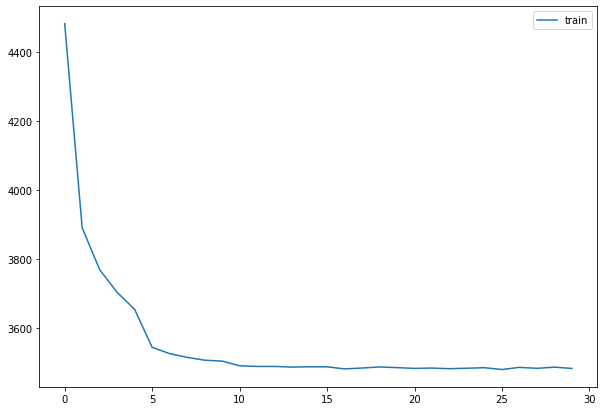

In [29]:
fig = plt.figure(figsize=(10, 7))
plt.plot(cvae_train_losses, label='train')
plt.legend(loc="upper right")
plt.show()

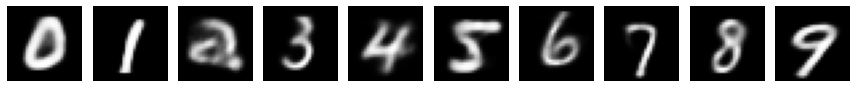

In [30]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
cvae.eval()

indexes_for_onehot = torch.IntTensor([*range(10)]).to(torch.int64)

with torch.no_grad():
    onehot_matrix = F.one_hot(indexes_for_onehot, 10)
    z = np.array([np.random.normal(0, 1, features) for i in range(10)])
    output = cvae.decode(torch.Tensor(z).cuda(), onehot_matrix.cuda()).cpu().detach().squeeze()

    fig, axes = plt.subplots(nrows=1, ncols=features, figsize=(12, 4))
    for idx in range(features):
        axes[idx].imshow(output[idx], cmap='gray')
        axes[idx].axis('off')
    fig.tight_layout()   

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

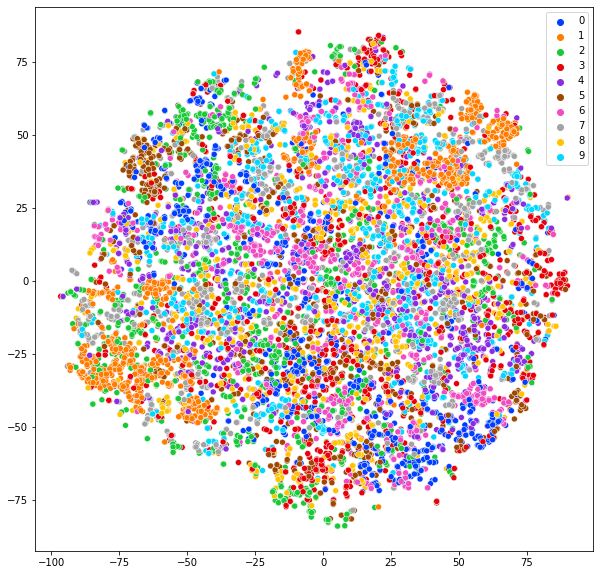

In [31]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

cvae.eval()
latent_representation = []
with torch.no_grad():
    for test_batch, class_num in test_loader:
        class_num = F.one_hot(class_num, 10)
        mu, logvar, class_num_1 = cvae.encode(test_batch.cuda(), class_num.cuda())
        z = cvae.gaussian_sampler(mu, logvar)
        latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

plt.figure(figsize = (10,10))
sns.scatterplot(pred[:, 0], pred[:, 1], hue=test_dataset.targets, palette=sns.color_palette('bright', 10))

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Полная каша по сравнению с VAE, никакого разделения на классы.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [32]:
noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)


def noisy_train_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        noisy_x = train_x + noise_factor * torch.FloatTensor(
            np.random.normal(loc=0.0, scale=1.0, size=train_x.shape))
        train_x = train_x.to(DEVICE)
        noisy_x = noisy_x.to(DEVICE)
        # zero  gradients
        optimizer.zero_grad()
        # get the output from the model
        pred_x, code = model(noisy_x)
        # calculate loss
        loss = loss_fn(pred_x, train_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item()
        counter += 1
    train_ep_loss /= counter
    return train_ep_loss


def noisy_val_epoch(model, val_loader, loss_fn):
    model.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        noisy_x = val_x + noise_factor * torch.FloatTensor(
            np.random.normal(loc=0.0, scale=1.0, size=val_x.shape))

        val_x = val_x.to(DEVICE)
        noisy_x = noisy_x.to(DEVICE)

        pred_x, code = model(noisy_x)

        # calculate loss
        loss = loss_fn(pred_x, val_x)
        val_ep_loss += loss.item()

        counter += 1
    val_ep_loss /= counter
    return val_ep_loss


def noisy_train(model, train_loader, val_loader, loss_fn, optimizer, epochs,
                scheduler=None):
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(epochs)):
        train_loss = noisy_train_epoch(model, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            valid_loss = noisy_val_epoch(model, val_loader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Epoch: {}/{}...".format(epoch + 1, epochs), "Loss: {:.6f}...".format(train_loss), "Val Loss: {:.6f}".format(valid_loss))
    return train_losses, valid_losses

In [33]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
train_loader = torch.utils.data.DataLoader(torch.Tensor(data_train.swapaxes(1,3).swapaxes(2,3)), batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.Tensor(data_valid.swapaxes(1,3).swapaxes(2,3)), batch_size=64, shuffle=False)

noisy_autoencoder = Autoencoder().to(DEVICE)

optimizer = torch.optim.AdamW(noisy_autoencoder.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = nn.MSELoss()

noisy_train_loss, noisy_valid_loss = noisy_train(noisy_autoencoder, train_loader, 
                                                 valid_loader, criterion, optimizer, 40, scheduler)

  2%|▎         | 1/40 [00:12<07:50, 12.06s/it]

Epoch: 1/40... Loss: 0.017588... Val Loss: 0.011984


  5%|▌         | 2/40 [00:23<07:35, 11.98s/it]

Epoch: 2/40... Loss: 0.010513... Val Loss: 0.009578


  8%|▊         | 3/40 [00:39<08:23, 13.61s/it]

Epoch: 3/40... Loss: 0.008650... Val Loss: 0.008747


 10%|█         | 4/40 [00:54<08:24, 14.00s/it]

Epoch: 4/40... Loss: 0.007148... Val Loss: 0.006295


 12%|█▎        | 5/40 [01:06<07:53, 13.54s/it]

Epoch: 5/40... Loss: 0.006221... Val Loss: 0.005934


 15%|█▌        | 6/40 [01:19<07:27, 13.17s/it]

Epoch: 6/40... Loss: 0.005520... Val Loss: 0.005386


 18%|█▊        | 7/40 [01:31<07:00, 12.74s/it]

Epoch: 7/40... Loss: 0.005380... Val Loss: 0.005213


 20%|██        | 8/40 [01:43<06:42, 12.59s/it]

Epoch: 8/40... Loss: 0.005261... Val Loss: 0.005178


 22%|██▎       | 9/40 [01:56<06:30, 12.61s/it]

Epoch: 9/40... Loss: 0.005194... Val Loss: 0.005027


 25%|██▌       | 10/40 [02:09<06:24, 12.81s/it]

Epoch: 10/40... Loss: 0.005087... Val Loss: 0.005013


 28%|██▊       | 11/40 [02:21<06:08, 12.70s/it]

Epoch: 11/40... Loss: 0.004928... Val Loss: 0.004839


 30%|███       | 12/40 [02:34<05:57, 12.75s/it]

Epoch: 12/40... Loss: 0.004927... Val Loss: 0.004839


 32%|███▎      | 13/40 [02:48<05:49, 12.96s/it]

Epoch: 13/40... Loss: 0.004876... Val Loss: 0.004782


 35%|███▌      | 14/40 [03:01<05:38, 13.00s/it]

Epoch: 14/40... Loss: 0.004850... Val Loss: 0.004773


 38%|███▊      | 15/40 [03:13<05:18, 12.73s/it]

Epoch: 15/40... Loss: 0.004826... Val Loss: 0.004767


 40%|████      | 16/40 [03:27<05:14, 13.10s/it]

Epoch: 16/40... Loss: 0.004788... Val Loss: 0.004736


 42%|████▎     | 17/40 [03:41<05:06, 13.32s/it]

Epoch: 17/40... Loss: 0.004776... Val Loss: 0.004739


 45%|████▌     | 18/40 [03:53<04:46, 13.04s/it]

Epoch: 18/40... Loss: 0.004765... Val Loss: 0.004726


 48%|████▊     | 19/40 [04:05<04:29, 12.84s/it]

Epoch: 19/40... Loss: 0.004756... Val Loss: 0.004724


 50%|█████     | 20/40 [04:17<04:10, 12.54s/it]

Epoch: 20/40... Loss: 0.004780... Val Loss: 0.004713


 52%|█████▎    | 21/40 [04:29<03:53, 12.31s/it]

Epoch: 21/40... Loss: 0.004751... Val Loss: 0.004712


 55%|█████▌    | 22/40 [04:41<03:38, 12.15s/it]

Epoch: 22/40... Loss: 0.004746... Val Loss: 0.004715


 57%|█████▊    | 23/40 [04:53<03:24, 12.05s/it]

Epoch: 23/40... Loss: 0.004767... Val Loss: 0.004713


 60%|██████    | 24/40 [05:04<03:11, 11.97s/it]

Epoch: 24/40... Loss: 0.004777... Val Loss: 0.004716


 62%|██████▎   | 25/40 [05:18<03:05, 12.37s/it]

Epoch: 25/40... Loss: 0.004753... Val Loss: 0.004722


 65%|██████▌   | 26/40 [05:29<02:50, 12.19s/it]

Epoch: 26/40... Loss: 0.004757... Val Loss: 0.004691


 68%|██████▊   | 27/40 [05:41<02:37, 12.09s/it]

Epoch: 27/40... Loss: 0.004736... Val Loss: 0.004715


 70%|███████   | 28/40 [05:53<02:24, 12.01s/it]

Epoch: 28/40... Loss: 0.004744... Val Loss: 0.004703


 72%|███████▎  | 29/40 [06:05<02:11, 11.95s/it]

Epoch: 29/40... Loss: 0.004756... Val Loss: 0.004711


 75%|███████▌  | 30/40 [06:17<01:59, 11.93s/it]

Epoch: 30/40... Loss: 0.004739... Val Loss: 0.004712


 78%|███████▊  | 31/40 [06:29<01:47, 11.89s/it]

Epoch: 31/40... Loss: 0.004775... Val Loss: 0.004725


 80%|████████  | 32/40 [06:40<01:34, 11.86s/it]

Epoch: 32/40... Loss: 0.004766... Val Loss: 0.004720


 82%|████████▎ | 33/40 [06:52<01:22, 11.85s/it]

Epoch: 33/40... Loss: 0.004742... Val Loss: 0.004715


 85%|████████▌ | 34/40 [07:04<01:10, 11.82s/it]

Epoch: 34/40... Loss: 0.004753... Val Loss: 0.004706


 88%|████████▊ | 35/40 [07:17<01:00, 12.16s/it]

Epoch: 35/40... Loss: 0.004754... Val Loss: 0.004710


 90%|█████████ | 36/40 [07:29<00:48, 12.06s/it]

Epoch: 36/40... Loss: 0.004753... Val Loss: 0.004726


 92%|█████████▎| 37/40 [07:41<00:35, 11.99s/it]

Epoch: 37/40... Loss: 0.004738... Val Loss: 0.004703


 95%|█████████▌| 38/40 [07:52<00:23, 11.95s/it]

Epoch: 38/40... Loss: 0.004757... Val Loss: 0.004701


 98%|█████████▊| 39/40 [08:04<00:11, 11.90s/it]

Epoch: 39/40... Loss: 0.004772... Val Loss: 0.004704


100%|██████████| 40/40 [08:16<00:00, 12.41s/it]

Epoch: 40/40... Loss: 0.004735... Val Loss: 0.004716


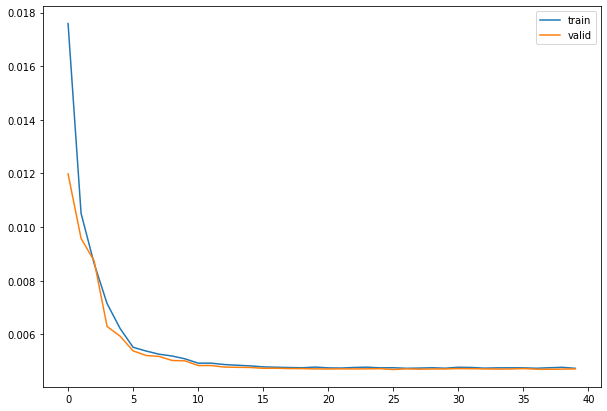

In [34]:
fig = plt.figure(figsize=(10, 7))
plt.plot(noisy_train_loss, label='train')
plt.plot(noisy_valid_loss, label='valid')
plt.legend(loc="upper right")
plt.show()

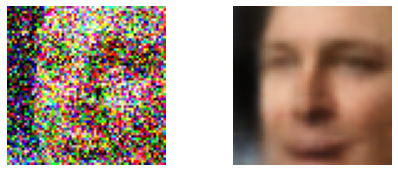

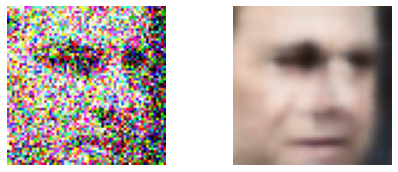

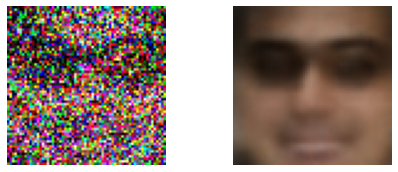

In [35]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
noisy_data = data_valid[:5] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_valid[:5].shape)
noisy_data = torch.FloatTensor(noisy_data.swapaxes(1,3).swapaxes(2,3))
noisy_autoencoder.eval()
with torch.no_grad():
    prediction, _ = noisy_autoencoder(noisy_data.to(DEVICE))
    for idx in range(3):
        plot_pair(noisy_data, prediction, idx)
        # слева зашумленный оригинал, справа - восстановленное изображение

#### Зашумленные картинки прилично восстановились.

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [36]:
# codes = <получите латентные представления картинок из трейна>
codes = []
for batch in train_loader:
    batch = batch.to(DEVICE)
    code = autoencoder.encoder(batch)
    codes.extend(code.cpu().detach().numpy())
codes = np.array(codes)

# LSHForest НЕТ в новых версиях sklearn - так что облом...

In [37]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest 
lshf = LSHForest(n_estimators=50).fit(codes)

ImportError: ignored

In [ ]:
def get_similar(image, n_neighbors=5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

    code = autoencoder.encode(image.to(DEVICE)).cpu().detach().numpy()

    (distances,), (idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

    return distances, data_train[idx]

In [ ]:
def show_similar(image):
    # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    distances, neighbors = get_similar(image, n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
# <тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>
show_similar(data_valid[0])